In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

os.chdir('../..')

from src.utils_k import add_type_features
from src.utils_r import generate_validation_set

pd.options.display.max_columns = 9999
pd.options.display.max_rows = 9999

In [2]:
from src.utils_f import duration_feature
import lightgbm as lgbm


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
test_session = pd.read_csv('data/raw/random_submission.csv')
test_tracking = pd.read_csv('data/raw/test_tracking.csv')
all_session = pd.read_csv('data/raw/train_session.csv') 
all_tracking = pd.read_csv('data/raw/train_tracking.csv')

In [5]:
trn_session, trn_tracking, val_session, val_tracking = generate_validation_set(all_session, all_tracking, test_size=0.4)

In [6]:
proc_train = add_type_features(trn_session[['sid']], trn_tracking)
proc_val = add_type_features(val_session[['sid']], val_tracking)
proc_all = add_type_features(all_session[['sid']], all_tracking)
proc_test = add_type_features(test_session, test_tracking)

In [7]:
proc_train = duration_feature(proc_train, trn_tracking)
proc_val = duration_feature(proc_val, val_tracking)
proc_all = duration_feature(proc_all, all_tracking)
proc_test = duration_feature(proc_test, test_tracking)

/anaconda/envs/kaggle/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [8]:
proc_train.head()

,sid,ADD_TO_BASKET_CAROUSEL_type,ADD_TO_BASKET_LP_type,ADD_TO_BASKET_LR_type,ADD_TO_BASKET_PA_type,ADD_TO_BASKET_SHOW_CASE_type,CAROUSEL_type,LIST_PRODUCT_type,PA_type,PRODUCT_CAROUSEL_type,PRODUCT_LP_type,PRODUCT_LR_type,PRODUCT_PA_type,PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_CAROUSEL_type,PURCHASE_PRODUCT_LP_type,PURCHASE_PRODUCT_LR_type,PURCHASE_PRODUCT_PA_type,PURCHASE_PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_UNKNOW_ORIGIN_type,SEARCH_type,SHOW_CASE_type,SUM_TYPE_type,ADD_TO_BASKET_sim_type,CAROUSEL_sim_type,LIST_PRODUCT_sim_type,PA_sim_type,PRODUCT_sim_type,PURCHASE_PRODUCT_sim_type,SEARCH_sim_type,SHOW_CASE_sim_type,SUM_TYPE_SIMPLIFIED_sim_type,TOTAL_DURATION
0,inxo2lfHOeGgN2ySgzK1hAKyCIt17p+honetBOQH4ICtTR...,0.0,0.0,0.000000,0.0,0.0,0.166667,0.0,0.041667,0.083333,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.000000,24.0,0.000000,0.166667,0.0,0.041667,0.125,0.0,0.666667,0.000000,24.0,7840.041643
1,4CGnnv6GOcYQp/kxVjcx8nN0u5HgaDaLQkC4xIteZJZ/wK...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.875000,0.000000,8.0,0.000000,0.000000,0.0,0.000000,0.125,0.0,0.875000,0.000000,8.0,288.199209
2,mh22mbOuRnDwAf2OWcrwwymfbZQ/CO3GQuNMO5NREgRV0t...,0.0,0.0,0.000000,0.0,0.0,0.833333,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.000000,6.0,0.000000,0.833333,0.0,0.000000,0.000,0.0,0.166667,0.000000,6.0,613.506545
3,K/+O1PWZ2vASLTrjvBFT7e62Vee1YyOxCrpMJNoL6edmuC...,0.0,0.0,0.181818,0.0,0.0,0.363636,0.0,0.090909,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272727,0.090909,11.0,0.181818,0.363636,0.0,0.090909,0.000,0.0,0.272727,0.090909,11.0,217.223808
4,+8SAgYuptilut4CKRE59ncZFDaF4Y+PX6yJ8g4HaALCxI7...,0.0,0.0,0.000000,0.0,0.0,0.200000,0.6,0.000000,0.000000,0.2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,5.0,0.000000,0.200000,0.6,0.000000,0.200,0.0,0.000000,0.000000,5.0,168.220206


# Validation

In [9]:
X_train = proc_train.drop('sid', axis=1).reset_index(drop=True)
y_train = trn_session.target.reset_index(drop=True)

X_val = proc_val.drop('sid', axis=1).reset_index(drop=True)
y_val = val_session.target.reset_index(drop=True)

X_test = proc_test.drop('sid', axis=1).reset_index(drop=True)

temp_columns = X_train.columns
X_val = X_val[temp_columns]
X_test = X_test[temp_columns]

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10).fit(X_train)

X_train_pca = (pca.transform(X_train))
X_val_pca = (pca.transform(X_val))

X_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_train_pca)], axis=1)
X_val = pd.concat([pd.DataFrame(X_val), pd.DataFrame(X_val_pca)], axis=1)

In [14]:
X_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_train_rf)], axis=1)
X_val = pd.concat([pd.DataFrame(X_val), pd.DataFrame(X_val_rf)], axis=1)

NameError: name 'X_train_rf' is not defined

In [36]:
# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.1,
    'metric': 'binary_logloss',
    'verbose': 1
    #'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_train, label=trn_session.target)
d_valid = lgbm.Dataset(X_val, label=val_session.target)

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=41, early_stopping_rounds=30)

[1]	valid_0's binary_logloss: 0.304764
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's binary_logloss: 0.29822
[3]	valid_0's binary_logloss: 0.293465
[4]	valid_0's binary_logloss: 0.289829
[5]	valid_0's binary_logloss: 0.286899
[6]	valid_0's binary_logloss: 0.284573
[7]	valid_0's binary_logloss: 0.282728
[8]	valid_0's binary_logloss: 0.281962
[9]	valid_0's binary_logloss: 0.280596
[10]	valid_0's binary_logloss: 0.279433
[11]	valid_0's binary_logloss: 0.278584
[12]	valid_0's binary_logloss: 0.278345
[13]	valid_0's binary_logloss: 0.277642
[14]	valid_0's binary_logloss: 0.277092
[15]	valid_0's binary_logloss: 0.276554
[16]	valid_0's binary_logloss: 0.276108
[17]	valid_0's binary_logloss: 0.27571
[18]	valid_0's binary_logloss: 0.275407
[19]	valid_0's binary_logloss: 0.275167
[20]	valid_0's binary_logloss: 0.274954
[21]	valid_0's binary_logloss: 0.274905
[22]	valid_0's binary_logloss: 0.274755
[23]	valid_0's binary_logloss: 0.274611
[24]	valid_0's binary_logloss

In [16]:
# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.1,
    'metric': 'binary_logloss',
    'verbose': 1
    #'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_train, label=trn_session.target)
d_valid = lgbm.Dataset(X_val, label=val_session.target)

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=100)

[1]	valid_0's binary_logloss: 0.304764
[2]	valid_0's binary_logloss: 0.29822
[3]	valid_0's binary_logloss: 0.293465
[4]	valid_0's binary_logloss: 0.289829
[5]	valid_0's binary_logloss: 0.286899
[6]	valid_0's binary_logloss: 0.284573
[7]	valid_0's binary_logloss: 0.282728
[8]	valid_0's binary_logloss: 0.281962
[9]	valid_0's binary_logloss: 0.280596
[10]	valid_0's binary_logloss: 0.279433
[11]	valid_0's binary_logloss: 0.278584
[12]	valid_0's binary_logloss: 0.278345
[13]	valid_0's binary_logloss: 0.277642
[14]	valid_0's binary_logloss: 0.277092
[15]	valid_0's binary_logloss: 0.276554
[16]	valid_0's binary_logloss: 0.276108
[17]	valid_0's binary_logloss: 0.27571
[18]	valid_0's binary_logloss: 0.275407
[19]	valid_0's binary_logloss: 0.275167
[20]	valid_0's binary_logloss: 0.274954
[21]	valid_0's binary_logloss: 0.274905
[22]	valid_0's binary_logloss: 0.274755
[23]	valid_0's binary_logloss: 0.274611
[24]	valid_0's binary_logloss: 0.274523
[25]	valid_0's binary_logloss: 0.274438
[26]	valid_

# Model

In [17]:
X_all = proc_all.drop('sid', axis=1).reset_index(drop=True)
y_all = all_session.target.reset_index(drop=True)

X_test = proc_test.drop('sid', axis=1).reset_index(drop=True)
temp_columns = X_all.columns
X_test = X_test[temp_columns]

In [18]:
scaler = StandardScaler()
scaler.fit(X_all)
X_all = scaler.transform(X_all)
X_test = scaler.transform(X_test)

In [19]:
pca = PCA(n_components = 10).fit(X_all)

X_all_pca = pd.DataFrame(pca.transform(X_all))
X_test_pca = pd.DataFrame(pca.transform(X_test))

X_all = pd.concat([pd.DataFrame(X_all), pd.DataFrame(X_all_pca)], axis=1)
X_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(X_test_pca)], axis=1)

In [20]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=20,
                              random_state=0)

clf.fit(X_all, y_all)

#pca = PCA(n_components = 31).fit(clf.apply(X_train))

#X_train_rf = (pca.transform(clf.apply(X_train)))
#X_val_rf = (pca.transform(clf.apply(X_val)))

X_all = pd.concat([X_all, pd.DataFrame(clf.apply(X_all))], axis=1)
X_test = pd.concat([X_test, pd.DataFrame(clf.apply(X_test))], axis=1)

In [21]:
import lightgbm as lgbm

# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.1,
    #'metric': 'binary_logloss',
    #'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_all, label=y_all)
#d_valid = lgbm.Dataset(X_val, label=y_val)

clf = lgbm.train(params, d_train,# valid_sets=[d_valid],
                num_boost_round=100)

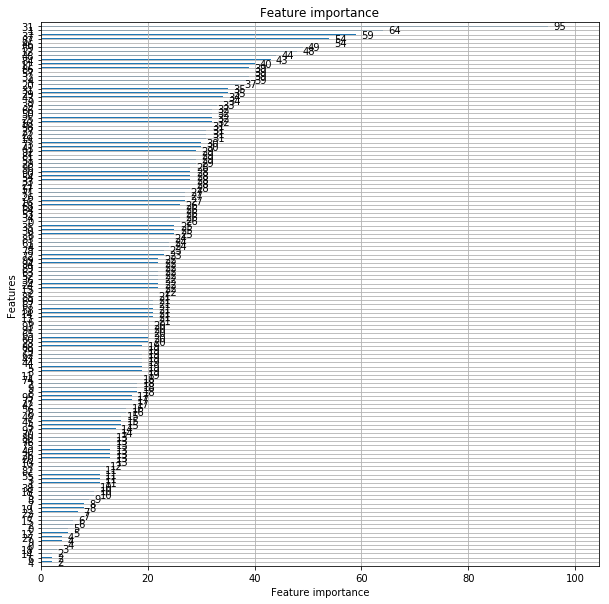

In [22]:
from matplotlib import rcParams
%matplotlib inline 

rcParams['figure.figsize'] = 10, 10
lgbm.plot_importance(clf)

In [23]:
count += 1
preds=clf.predict(X_test)
test_session['target'] = preds
# test_session.to_csv(f'data/submissions/kervy_{count}_submit.csv', index=False)

NameError: name 'count' is not defined

In [24]:
count = 7

In [25]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,0,1,2,3,4,5,6,7,8,9
0,-0.138145,-0.093051,-0.322523,-0.04508,-0.054139,-0.331188,-0.357793,-0.445112,0.567509,-0.227689,-0.360090,-0.172671,-0.181197,-0.030073,-0.017845,-0.067902,-0.012395,-0.012041,-0.080104,1.111858,-0.431899,0.942648,-0.373516,-0.331188,-0.357793,-0.445112,-0.154530,-0.101517,1.111858,-0.431899,0.942648,0.916403,1.522396,0.759925,0.688784,-0.040368,0.408970,-0.017272,1.217480,-1.022033,0.166642,0.081984
1,-0.138145,-0.093051,-0.322523,-0.04508,-0.054139,-0.956766,-0.357793,-0.712659,-0.393631,-0.227689,0.311095,-0.172671,-0.181197,-0.030073,-0.017845,-0.067902,-0.012395,-0.012041,-0.080104,1.789222,-0.431899,-0.153072,-0.373516,-0.956766,-0.357793,-0.712659,-0.154530,-0.101517,1.789222,-0.431899,-0.153072,-0.335600,2.950315,0.004897,0.388411,-0.348015,-0.359549,-0.852967,-0.251825,-0.590512,0.402881,-0.004344
2,-0.138145,-0.093051,-0.322523,-0.04508,-0.054139,2.171124,-0.357793,-0.712659,-0.393631,-0.227689,-0.695683,-0.172671,-0.181197,-0.030073,-0.017845,-0.067902,-0.012395,-0.012041,-0.080104,-0.513815,-0.431899,-0.290037,-0.373516,2.171124,-0.357793,-0.712659,-1.024832,-0.101517,-0.513815,-0.431899,-0.290037,-0.281668,-1.737294,1.749111,-0.714982,-0.300330,-0.395958,-0.294266,-0.539811,-2.141432,0.563212,0.119756
3,-0.138145,-0.093051,2.957465,-0.04508,-0.054139,0.408131,-0.357793,-0.128920,-0.393631,-0.227689,-0.695683,-0.172671,-0.181197,-0.030073,-0.017845,-0.067902,-0.012395,-0.012041,-0.080104,-0.168975,0.131392,0.052376,2.600868,0.408131,-0.357793,-0.128920,-1.024832,-0.101517,-0.168975,0.131392,0.052376,-0.347367,-0.102508,0.823671,-0.275114,1.348411,1.979565,1.711024,-2.635936,-0.232908,-0.128427,-0.222459
4,-0.138145,-0.093051,-0.322523,-0.04508,-0.054139,-0.206073,2.922771,-0.712659,-0.393631,3.507967,-0.695683,-0.172671,-0.181197,-0.030073,-0.017845,-0.067902,-0.012395,-0.012041,-0.080104,-1.055706,-0.431899,-0.358519,-0.373516,-0.206073,2.922771,-0.712659,0.367652,-0.101517,-1.055706,-0.431899,-0.358519,-0.355491,-2.221367,-1.816500,3.742510,0.165010,-2.906247,0.422182,-0.855773,0.256912,0.086476,0.156768


In [26]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(loss_function='Logloss')

In [27]:
model.fit(X_train, y_train)

0:	learn: 0.6309709	total: 71.4ms	remaining: 1m 11s
1:	learn: 0.5784362	total: 91.3ms	remaining: 45.5s
2:	learn: 0.5337454	total: 115ms	remaining: 38.4s
3:	learn: 0.4956539	total: 137ms	remaining: 34.2s
4:	learn: 0.4624037	total: 157ms	remaining: 31.3s
5:	learn: 0.4354163	total: 176ms	remaining: 29.1s
6:	learn: 0.4115601	total: 196ms	remaining: 27.8s
7:	learn: 0.3922549	total: 215ms	remaining: 26.6s
8:	learn: 0.3749134	total: 235ms	remaining: 25.8s
9:	learn: 0.3609729	total: 262ms	remaining: 25.9s
10:	learn: 0.3485001	total: 281ms	remaining: 25.3s
11:	learn: 0.3382415	total: 301ms	remaining: 24.8s
12:	learn: 0.3291522	total: 321ms	remaining: 24.4s
13:	learn: 0.3215198	total: 342ms	remaining: 24.1s
14:	learn: 0.3145927	total: 362ms	remaining: 23.7s
15:	learn: 0.3086136	total: 381ms	remaining: 23.4s
16:	learn: 0.3037902	total: 402ms	remaining: 23.2s
17:	learn: 0.2992824	total: 421ms	remaining: 23s
18:	learn: 0.2954528	total: 440ms	remaining: 22.7s
19:	learn: 0.2919266	total: 461ms	remain

In [28]:
pred = model.predict_proba(X_val)

In [29]:
from sklearn.metrics import log_loss

log_loss(y_val, pred)

0.27565615191472603

In [31]:
model.fit(X_all, y_all)

0:	learn: 0.6217768	total: 27.1ms	remaining: 27s
1:	learn: 0.5626457	total: 50.2ms	remaining: 25s
2:	learn: 0.5141207	total: 80.2ms	remaining: 26.7s
3:	learn: 0.4742719	total: 103ms	remaining: 25.8s
4:	learn: 0.4410671	total: 130ms	remaining: 25.8s
5:	learn: 0.4136137	total: 154ms	remaining: 25.6s
6:	learn: 0.3911420	total: 178ms	remaining: 25.3s
7:	learn: 0.3720976	total: 201ms	remaining: 25s
8:	learn: 0.3563681	total: 226ms	remaining: 24.9s
9:	learn: 0.3437468	total: 253ms	remaining: 25s
10:	learn: 0.3333808	total: 276ms	remaining: 24.8s
11:	learn: 0.3240043	total: 299ms	remaining: 24.6s
12:	learn: 0.3159691	total: 323ms	remaining: 24.5s
13:	learn: 0.3093189	total: 348ms	remaining: 24.5s
14:	learn: 0.3043828	total: 371ms	remaining: 24.3s
15:	learn: 0.2993927	total: 395ms	remaining: 24.3s
16:	learn: 0.2950967	total: 421ms	remaining: 24.3s
17:	learn: 0.2917442	total: 446ms	remaining: 24.3s
18:	learn: 0.2887549	total: 476ms	remaining: 24.6s
19:	learn: 0.2859803	total: 506ms	remaining: 2

In [32]:
preds = model.predict(X_test)

In [33]:
count = 0
preds=clf.predict(X_test)
test_session['target'] = preds
test_session.to_csv(f'data/submissions/chu_{count}_submit.csv', index=False)

In [42]:
X_test['ADD_TO_BASKET_CAROUSEL_type'] = 0.0

In [43]:
X_test.head()

,ADD_TO_BASKET_CAROUSEL_type,ADD_TO_BASKET_LP_type,ADD_TO_BASKET_LR_type,ADD_TO_BASKET_PA_type,ADD_TO_BASKET_SHOW_CASE_type,CAROUSEL_type,LIST_PRODUCT_type,PA_type,PRODUCT_CAROUSEL_type,PRODUCT_LP_type,PRODUCT_LR_type,PRODUCT_PA_type,PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_CAROUSEL_type,PURCHASE_PRODUCT_LP_type,PURCHASE_PRODUCT_LR_type,PURCHASE_PRODUCT_PA_type,PURCHASE_PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_UNKNOW_ORIGIN_type,SEARCH_type,SHOW_CASE_type,SUM_TYPE_type,ADD_TO_BASKET_sim_type,CAROUSEL_sim_type,LIST_PRODUCT_sim_type,PA_sim_type,PRODUCT_sim_type,PURCHASE_PRODUCT_sim_type,SEARCH_sim_type,SHOW_CASE_sim_type,SUM_TYPE_SIMPLIFIED_sim_type,TOTAL_DURATION
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.9375,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.062500,16.0,0.0,0.000000,0.9375,0.000000,0.00,0.0,0.00,0.062500,16.0,304.087885
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.250000,4.0,0.0,0.000000,0.0000,0.000000,0.00,0.0,0.75,0.250000,4.0,140.971932
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.000000,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.000000,4.0,0.0,0.000000,0.0000,0.000000,0.25,0.0,0.75,0.000000,4.0,352.476459
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.250000,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.000000,4.0,0.0,0.000000,0.0000,0.250000,0.25,0.0,0.50,0.000000,4.0,644.327849
4,0.0,0.0,0.0,0.0,0.0,0.333333,0.0000,0.333333,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.333333,3.0,0.0,0.333333,0.0000,0.333333,0.00,0.0,0.00,0.333333,3.0,206.997212


In [ ]:
ori